In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl 
import numpy.random as npr
from scipy.optimize import minimize
from scipy.stats import ortho_group

import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.linear_model import RidgeCV, LinearRegression

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)

## Ridge

## Plot Results from files

In [23]:
# file = open('ridge_identity_bias_variance.txt', 'rb')
# results_identity = pickle.load(file)
# file.close()

# file = open('ridge_singular_bias_variance.txt', 'rb')
# results_singular = pickle.load(file)
# file.close()

In [3]:
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
# mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
# pylab.rcParams['xtick.major.pad']=5
# pylab.rcParams['ytick.major.pad']=5

## Run to get results

In [9]:

npr.seed(0)
num_trials = 20
gammas = np.array([5e-2, 1e-1, 0.2, 0.5, 0.75, 0.9, 0.95, 1.,  1.05,  1.25, 1.5,  1.75, 1.95, 2., 2.05, 2.25, 2.5, 5., 10.])

noise_std = .1
n_test = 5000

# ds = [400]
# ns = np.asarray(ds[0]/gammas, dtype=int)

ns = np.array([100])
ds = np.asarray(ns[0]*gammas, dtype=int)

ols_train = np.zeros((num_trials, len(ds), len(ns)))
ols_test = np.zeros((num_trials, len(ds), len(ns)))
ols_pred_bias = np.zeros((len(ds), len(ns)))
ols_pred_variance = np.zeros((len(ds), len(ns)))


mse_train = np.zeros((num_trials, len(ds), len(ns)))
mse_test = np.zeros((num_trials, len(ds), len(ns)))
t_pred_bias = np.zeros((len(ds), len(ns)))
t_pred_variance = np.zeros((len(ds), len(ns)))


## choice of singular or not, just change this prefix
prefix = 'ridge_identity_sigma_%d_'%noise_std
# prefix = 'ridge_singular_sigma_%d_'%noise_std ##

X_train = npr.randn(max(ns), max(ds))
X_test = npr.randn(n_test, max(ds))

d0 = 50

beta_fixed = npr.randn(d0)
beta_fixed /= npl.norm(beta_fixed)

y_train_star = X_train[:, :d0] @ beta_fixed
y_test =  X_test[:, :d0] @ beta_fixed

for k, n in enumerate(ns):
    
    for j, d in enumerate(ds):

        t_preds = np.zeros((num_trials, n_test))
        ols_preds = np.zeros((num_trials, n_test))

        for i in range(num_trials):
            if i==0:
                print(i, d, n)
                
            y_train = y_train_star + noise_std * npr.randn(n)
            
            m = RidgeCV(fit_intercept=False, alphas=np.logspace(-4, 4, num=40, base=10))
            m.fit(X_train[:, :d], y_train)
            tvars[i, :] = m.coef_
            t_preds[i, :] = X_test[:, :d] @ m.coef_
            
            mse_train[i, j, k] = npl.norm(y_train - X_train[:, :d] @ m.coef_)**2 / n
            mse_test[i, j, k] = npl.norm(y_test - t_preds[i, :])**2 /  n_test
                        
            ols = LinearRegression(fit_intercept=False)
            ols.fit(X_train[:, :d], y_train)
            ols_preds[i, :] = X_test[:, :d] @ ols.coef_
            
            ols_train[i, j, k] = npl.norm(y_train - X_train[:, :d] @ ols.coef_)**2 / n
            ols_test[i, j, k] = npl.norm(y_test - ols_preds[i, :])**2 / n_test
        
        pmean = t_preds.mean(0)
        t_pred_variance[j, k] = np.sum((t_preds - pmean)**2)/num_trials/n_test
        t_pred_bias[j, k]  = np.sum((pmean-y_test)**2)/n_test

        pmean = ols_preds.mean(0)
        ols_pred_variance[j, k] = np.sum((ols_preds - pmean)**2)/num_trials/n_test
        ols_pred_bias[j, k]  = np.sum((pmean - y_test)**2)/n_test

0 5 100
0 10 100
0 20 100
0 50 100
0 75 100
0 90 100
0 95 100
0 100 100
0 105 100
0 125 100
0 150 100
0 175 100
0 195 100
0 200 100
0 204 100
0 225 100
0 250 100
0 500 100
0 1000 100


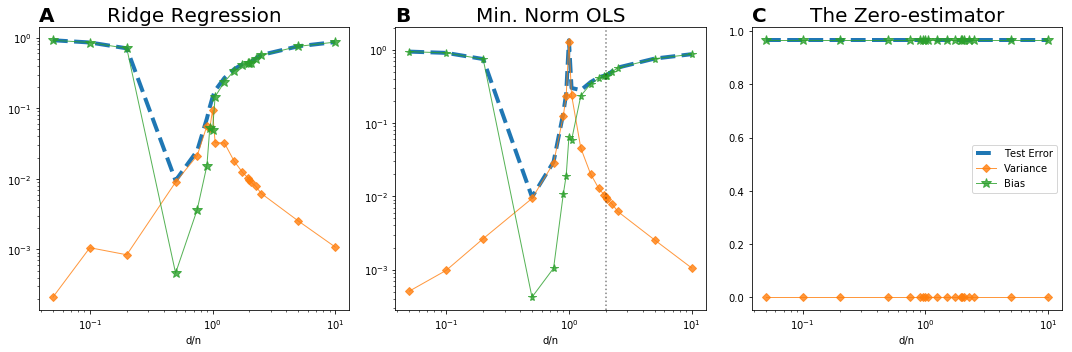

In [21]:
plt.figure(figsize=[15, 5])
for j, n in enumerate(ns):
    plt.subplot(1, 3, 1)
    plt.loglog(gammas, mse_test.mean(0)[:, j], label='Test Error', linestyle='--', linewidth=4.)
    plt.loglog(gammas, t_pred_variance[:, j], label='Variance', linestyle='-', linewidth=1, marker='D', markersize=5, alpha=.8)
    plt.loglog(gammas, t_pred_bias[:, j], label='Bias', linestyle='-', linewidth=1, marker='*', markersize=10, alpha=.8)
    plt.title('A', fontweight='bold', loc='left', fontsize=20)
    plt.title("Ridge Regression", fontsize=20)
    plt.xlabel('d/n')
    
    plt.subplot(1, 3, 2)
    plt.loglog(gammas, ols_test.mean(0)[:, j], label='Test Error', linestyle='--', linewidth=4.)
    plt.loglog(gammas, ols_pred_variance[:, j], label='Variance', linestyle='-', linewidth=1, marker='D', markersize=5, alpha=.8)
    plt.loglog(gammas, ols_pred_bias[:, j], label='Bias', linestyle='-', linewidth=1, marker='*', markersize=8, alpha=.8)
    plt.axvline(2., color='k', linestyle=':', alpha=0.5)
    plt.title('B', fontweight='bold', loc='left', fontsize=20)
    plt.title("Min. Norm OLS", fontsize=20)
    plt.xlabel('d/n')
#     plt.legend()

    plt.subplot(1, 3, 3)
    plt.semilogx(gammas, npl.norm(y_test)**2*np.ones_like(gammas)/n_test, label='Test Error', linestyle='--', linewidth=4.)
    plt.semilogx(gammas, np.zeros_like(gammas), label='Variance', linestyle='-', linewidth=1, marker='D', markersize=5, alpha=.8)
    plt.semilogx(gammas, npl.norm(y_test)**2*np.ones_like(gammas)/n_test, label='Bias', linestyle='-', linewidth=1, marker='*', markersize=10, alpha=.8)
    plt.title('C', fontweight='bold', loc='left', fontsize=20)
    plt.title("The Zero-estimator",  fontsize=20)
    plt.xlabel('d/n')
    plt.legend()
plt.tight_layout()
# plt.savefig(prefix+'bias_variance.pdf')
plt.show()


## save results

In [119]:
# file_name = prefix+'bias_variance.txt'

# results = {'ns': ns, 'ds': ds, 'gammas': gammas, 'num_trials': num_trials, 'beta_norm': npl.norm(beta_star),  
#            'mse_test': mse_test, 't_pred_variance': t_pred_variance, 't_pred_bias':t_pred_bias,
#            'ols_test': ols_test, 'ols_pred_variance': ols_pred_variance, 'ols_pred_bias':ols_pred_bias,
           
#            'mse': mse_beta, 't_variance': t_variance, 't_bias':t_bias,
#            'ols_mse': ols_mse_beta, 'ols_variance': ols_variance, 'ols_bias':ols_bias,
#           }
# #     'mdl_practice': mdl_practice, 'mdl_theory_lam': mdl_theory_lam, 'mdl_theory':mdl_theory,  'mdl_theory_mean': mdl_theory_mean}
# file = open(file_name, 'wb')
# pickle.dump(results, file)
# file.close()